# Сравнение активаций классов

Вы когда-нибудь задумывались, как нейросетевая модель, например ResNet, принимает решение о том, что на изображении - кошка или полевой цветок? Class Activation Mappings (CAM) может дать некоторое представление об этом процессе, наложив тепловую карту на исходное изображение, можно увидеть где наша модель решила, что эта кошка действительно кошка.

Для этого воспользуемся одной из фотографий кошки

In [6]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

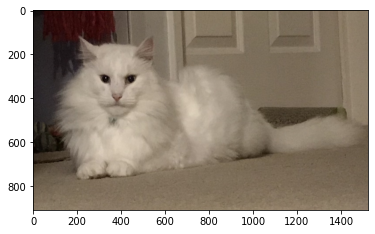

In [8]:
image = Image.open("casper2.jpg")
imshow(image)

Настроим некоторые преобразования torchvision, чтобы масштабировать изображение до размера 224x224, необходимого для ResNet, а также нормализовать его до среднего значения/std для ImageNet.

In [9]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [10]:
tensor = preprocess(image)

In [11]:
prediction_var = Variable(tensor.unsqueeze(0).cuda(), requires_grad=True)

Преобразовав наше изображение в переменную PyTorch, нам нужна модель для генерации предсказания. Давайте воспользуемся ResNet18, переведем ее в режим оценки и запустим на GPU с помощью библиотек CUDA.

In [12]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Этот небольшой кусок кода взят из курса Jeremy Howard's [fast.ai](https://fast.ai). По сути, он позволяет легко прикрепить к любой модели (или любой части модели - здесь мы собираемся взять финальный слой convnet в ResNet18) **хук**, который сохранит активационные характеристики как переменную экземпляра. 

In [14]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [15]:
final_layer = model._modules.get('layer4')


In [16]:
activated_features = SaveFeatures(final_layer)

Установив это, мы пропускаем изображение через нашу модель и получаем прогноз. Затем мы пропускаем ее через слой softmax, чтобы преобразовать в вероятности. 

In [17]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [18]:
activated_features.remove()

Используя `topk()`, мы видим, что наша модель на 78% уверена, что эта картинка относится к классу 283. Если посмотреть на это в [ImageNet classes](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), то мы получим... "персидская кошка". Что, я бы сказал, не является ужасным предположением!

In [19]:
topk(pred_probabilities,1)

torch.return_types.topk(
values=tensor([0.7832], device='cuda:0'),
indices=tensor([283], device='cuda:0'))

Сделав прогноз, давайте посмотрим, на чем нейронная сеть сосредоточила свое внимание. Метод `getCAM()` здесь берет активированные признаки конвсети, веса полностью связанного слоя (на стороне объединения средних) и индекс класса, который мы хотим исследовать (283 в нашем случае). Мы индексируем полностью связанный слой, чтобы получить веса для этого класса, и вычисляем точечное произведение с нашими характеристиками из изображения. 

([этот код основан на статье, в которой был представлен CAM] (http://cnnlocalization.csail.mit.edu/))

In [20]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]


In [21]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [22]:
weight_softmax_params

[Parameter containing:
 tensor([[-0.0185, -0.0705, -0.0518,  ..., -0.0390,  0.1735, -0.0410],
         [-0.0818, -0.0944,  0.0174,  ...,  0.2028, -0.0248,  0.0372],
         [-0.0332, -0.0566, -0.0242,  ..., -0.0344, -0.0227,  0.0197],
         ...,
         [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
         [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
         [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-2.6341e-03,  3.0005e-03,  6.5581e-04, -2.6909e-02,  6.3637e-03,
          1.3260e-02, -1.1178e-02,  2.0639e-02, -3.6373e-03, -1.2325e-02,
         -1.2629e-02, -7.2057e-03, -1.9321e-02, -2.4960e-02, -1.1885e-02,
         -8.3259e-03, -9.5745e-03, -1.6658e-02,  9.1804e-03, -1.5354e-02,
          7.1358e-03,  3.0737e-02,  1.3239e-02, -7.7528e-03,  4.7448e-03,
          1.1175e-02,  1.5949e-02, -1.6712e-02, -1.0130e-03, -3.7167e-03,
          6.5269e-03, -1

In [23]:
class_idx = topk(pred_probabilities,1)[1].int()

In [24]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )


Теперь мы можем увидеть нашу тепловую карту и наложить ее на Каспера. Это не делает его счастливее, но мы видим, где именно модель составила свое мнение о нем

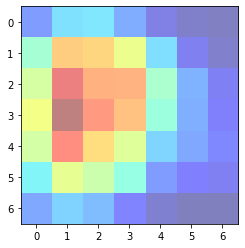

In [25]:
imshow(overlay[0], alpha=0.5, cmap='jet')


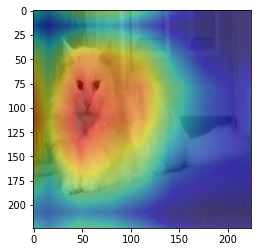

In [26]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

Но подождите, это еще не все - мы также можем посмотреть на второй выбор модели в пользу Casper.

In [27]:
class_idx = topk(pred_probabilities,2)[1].int()

In [28]:
class_idx

tensor([283, 332], device='cuda:0', dtype=torch.int32)

In [29]:
overlay = getCAM(activated_features.features, weight_softmax, 332 )


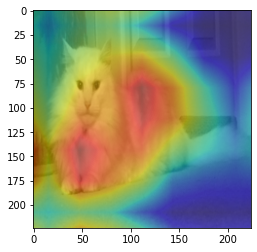

In [30]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

Хотя тепловая карта похожа, сеть больше фокусируется на его _пушистой_ шерсти, чтобы предположить, что он может относиться к классу 332 - ангорский кролик. И, в конце концов, он турецкий ангорский кот...